# Evaluate methods for taking gradients to determine current

Find the axial current in each x-y plane and compare to Jason's paper. 
Concentrate on non modified second two planes first (0.419, 0.357).

In [122]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.spatial import Delaunay
import matplotlib.tri as tri
from scipy.interpolate import LinearNDInterpolator

In [123]:
import sys
sys.path.append('/Users/vonderlinden2/rsx_analysis/writing_to_vtk/source')
import structured_3d_vtk as struc_3d
reload(struc_3d)
import maximum_extents as extent
reload(extent)

<module 'maximum_extents' from '/Users/vonderlinden2/rsx_analysis/writing_to_vtk/source/maximum_extents.pyc'>

In [124]:
def interpolate_plane(plane_to_interpolate, grid_points):

    bx_measurements = struc_3d.read_idl('bx')
    by_measurements = struc_3d.read_idl('by')
    bz_measurements = struc_3d.read_idl('bz')

    for plane in [0.249, 0.302, 0.357, 0.416]:
        bx_measurements[plane] = struc_3d.average_duplicate_points(bx_measurements[plane])
        by_measurements[plane] = struc_3d.average_duplicate_points(by_measurements[plane])
        bz_measurements[plane] = struc_3d.average_duplicate_points(bz_measurements[plane])

    direction_measurements = [bx_measurements, by_measurements, bz_measurements] 

    interpolated_vectors = []
    interpolators = []
    tri_interpolators = []
    for time_point in xrange(21):
        print time_point
        points = []
        values = []
        for measurements in direction_measurements:
            (points_direction,
             values_direction) = struc_3d.read_points_from_measurement_dict(measurements,
                                                                            time_point,
                                                                            [plane_to_interpolate])
            points.append(points_direction)
            values.append(values_direction)
    
        points[0] = np.delete(points[0], 2, axis=1)
        points[1] = np.delete(points[1], 2, axis=1)
        points[2] = np.delete(points[2], 2, axis=1)
        interpolated_vector = struc_3d.interpolate_vector(grid_points, points, values)
    
        assert np.sum(np.isnan(interpolated_vector[0])) == 0
        assert np.sum(np.isnan(interpolated_vector[1])) == 0
        assert np.sum(np.isnan(interpolated_vector[2])) == 0
    
        sizes = (np.unique(grid_points[:, 0]).size,
                 np.unique(grid_points[:, 1]).size)
    
        grid_swapped = np.swapaxes(grid_points, 0, 1)
        grid_x = np.resize(grid_swapped[0], (sizes[0], sizes[1]))
        grid_y = np.resize(grid_swapped[1], (sizes[0], sizes[1]))
        grid = np.asarray([grid_x, grid_y])
    
        interpolated_vector = np.asarray(interpolated_vector)
        vector_swapped = np.swapaxes(interpolated_vector, 0, 1)
        vector_x = np.resize(vector_swapped[:, 0], (sizes[0], sizes[1]))
        vector_y = np.resize(vector_swapped[:, 1], (sizes[0], sizes[1]))
        vector = np.asarray([vector_x, vector_y])
    
        interpolated_vectors.append(vector)
    
    
        interpolator_x = LinearNDInterpolator(points[0], values[0])
        
        
        interpolator_y = LinearNDInterpolator(points[1], values[1])
        interpolator_z = LinearNDInterpolator(points[2], values[2])
        
        interpolators.append([interpolator_x, 
                              interpolator_y, 
                              interpolator_z])
    
        delaunay_x = Delaunay(points[0])
        delaunay_y = Delaunay(points[1])
        delaunay_z = Delaunay(points[2])
    
        triangulation_x = tri.Triangulation(points[0][:, 0], 
                                            points[0][:, 1], 
                                            triangles=delaunay_x.simplices)
        triangulation_y = tri.Triangulation(points[1][:, 0], 
                                            points[1][:, 1], 
                                            triangles=delaunay_y.simplices)
        triangulation_z = tri.Triangulation(points[2][:, 0], 
                                            points[2][:, 1], 
                                            triangles=delaunay_z.simplices)
    
        tri_interpolator_x = tri.triinterpolate.LinearTriInterpolator(triangulation_x, 
                                                                      values[0])
        tri_interpolator_y = tri.triinterpolate.LinearTriInterpolator(triangulation_y, 
                                                                      values[1])
        tri_interpolator_z = tri.triinterpolate.LinearTriInterpolator(triangulation_z, 
                                                                      values[2])
        tri_interpolators.append([tri_interpolator_x, 
                                  tri_interpolator_y, 
                                  tri_interpolator_z])
        
    return interpolated_vectors, interpolators, tri_interpolators

In [136]:
def make_grid_points(x_min, x_max, 
                     y_min, y_max, 
                     z_min, z_max,
                     spatial_increment):
    bounds = ((x_min, x_max), (y_min, y_max), (z_min, z_max)) 

    x_coord = np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment))
    y_coord = np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment))

    mesh = np.asarray(np.meshgrid(x_coord, y_coord, indexing='ij'))
    grid_points = np.dstack(map(np.ravel, mesh))[0]
    
    return  mesh, grid_points

In [150]:
def plot_three_current_methods(vectors, tri_interpolators, grid, time_point):

    figure, axes = plt.subplots(1, 3, figsize=((50, 20)))

    ## 1st order difference of interpolated data
    axes[0].set_title('1st order diff of interpolation', fontsize=30)
    j_z = (np.diff(vectors[time_point][0, :, :][5:-5:5, 5:-5:5], axis=0)[:,1:]*5e3 - 
           np.diff(vectors[time_point][1, :, :][5:-5:5, 5:-5:5], axis=1)[1:,:]*5e3)/(1.26e-6)/1e3
    axes[0].quiver(grid[0, :, :][::5, ::5], grid[1, :, :][::5, ::5], 
                   vectors[time_point][0, :, :][::5, ::5], vectors[time_point][1, :, :][::5, ::5])
    bound = j_z.max() if j_z.max() > np.abs(j_z.min()) else np.abs(j_z.min())
    contour = axes[0].contourf(grid[0, :, :][10:-5:5, 10:-5:5], grid[1, :, :][10:-5:5, 10:-5:5], 
                               j_z, alpha=0.2, cmap='BrBG_r', vmax=bound, vmin=-bound)
    divider = make_axes_locatable(axes[0])
    colorbar_axis = divider.append_axes("right", size="10%", pad=0.1)
    colorbar = plt.colorbar(contour, cax=colorbar_axis)
    colorbar.set_label(r'$j_z [\frac{kA}{m^2}]$', fontsize=25, rotation='horizontal')

    ## 2nd order difference of interpolated data
    axes[1].set_title('2nd order diff of interpolation', fontsize=30)
    j_z = (np.gradient(vectors[time_point][0, :, :][5:-5:5, 5:-5:5])[0]*5e3 - 
           np.gradient(vectors[time_point][1, :, :][5:-5:5, 5:-5:5])[1]*5e3)/(1.26e-6)/1e3
    axes[1].quiver(grid[0, :, :][::5, ::5], grid[1, :, :][::5, ::5], 
                   vectors[time_point][0, :, :][::5, ::5], vectors[time_point][1, :, :][::5, ::5])
    bound = j_z.max() if j_z.max() > np.abs(j_z.min()) else np.abs(j_z.min())
    contour = axes[1].contourf(grid[0, :, :][5:-5:5, 5:-5:5], grid[1, :, :][5:-5:5, 5:-5:5], 
                               j_z, alpha=0.2, cmap='BrBG_r', vmax=bound, vmin=-bound)
    divider = make_axes_locatable(axes[1])
    colorbar_axis = divider.append_axes("right", size="10%", pad=0.1)
    colorbar = plt.colorbar(contour, cax=colorbar_axis)
    colorbar.set_label(r'$j_z [\frac{kA}{m^2}]$', fontsize=25, rotation='horizontal')


    ## 2nd order difference of triangulated data
    axes[2].set_title('2nd order of triangulated data', fontsize=30)
    spatial_increment = 0.001
    x_min, x_max = -0.027, 0.022
    y_min, y_max = -0.021, 0.0295 
    mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)), 
                       np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)))
    
    j_z = (np.asarray(tri_interpolators[time_point][1].gradient(grid[0][5:-5:5, 5:-5:5], grid[1][5:-5:5, 5:-5:5]))[0] - 
           np.asarray(tri_interpolators[time_point][0].gradient(grid[0][5:-5:5, 5:-5:5], grid[1][5:-5:5, 5:-5:5]))[1])/(1.26e-6)/1e3

    axes[2].quiver(grid[0, :, :][::5, ::5], grid[1, :, :][::5, ::5], 
                   vectors[time_point][0, :, :][::5, ::5], vectors[time_point][1, :, :][::5, ::5])
    bound = j_z.max() if j_z.max() > np.abs(j_z.min()) else np.abs(j_z.min())
    contour = axes[2].contourf(grid[0, :, :][5:-5:5, 5:-5:5], grid[1, :, :][5:-5:5, 5:-5:5], 
                               j_z, alpha=0.2, cmap='BrBG_r', vmax=bound, vmin=-bound)
    divider = make_axes_locatable(axes[2])
    colorbar_axis = divider.append_axes("right", size="10%", pad=0.1)
    colorbar = plt.colorbar(contour, cax=colorbar_axis)
    colorbar.set_label(r'$j_z [\frac{kA}{m^2}]$', fontsize=25, rotation='horizontal')

# Axial current z=0.249m plane

In [148]:
spatial_increment = 0.001
limits = extent.maximum_b_extent()[0.416]

mesh, grid_points = make_grid_points(spatial_increment=spatial_increment, **limits)

(z0416_interpolated_vectors,
 z0416_interpolators,
 z0416_tri_interpolators) = interpolate_plane(0.416, grid_points)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


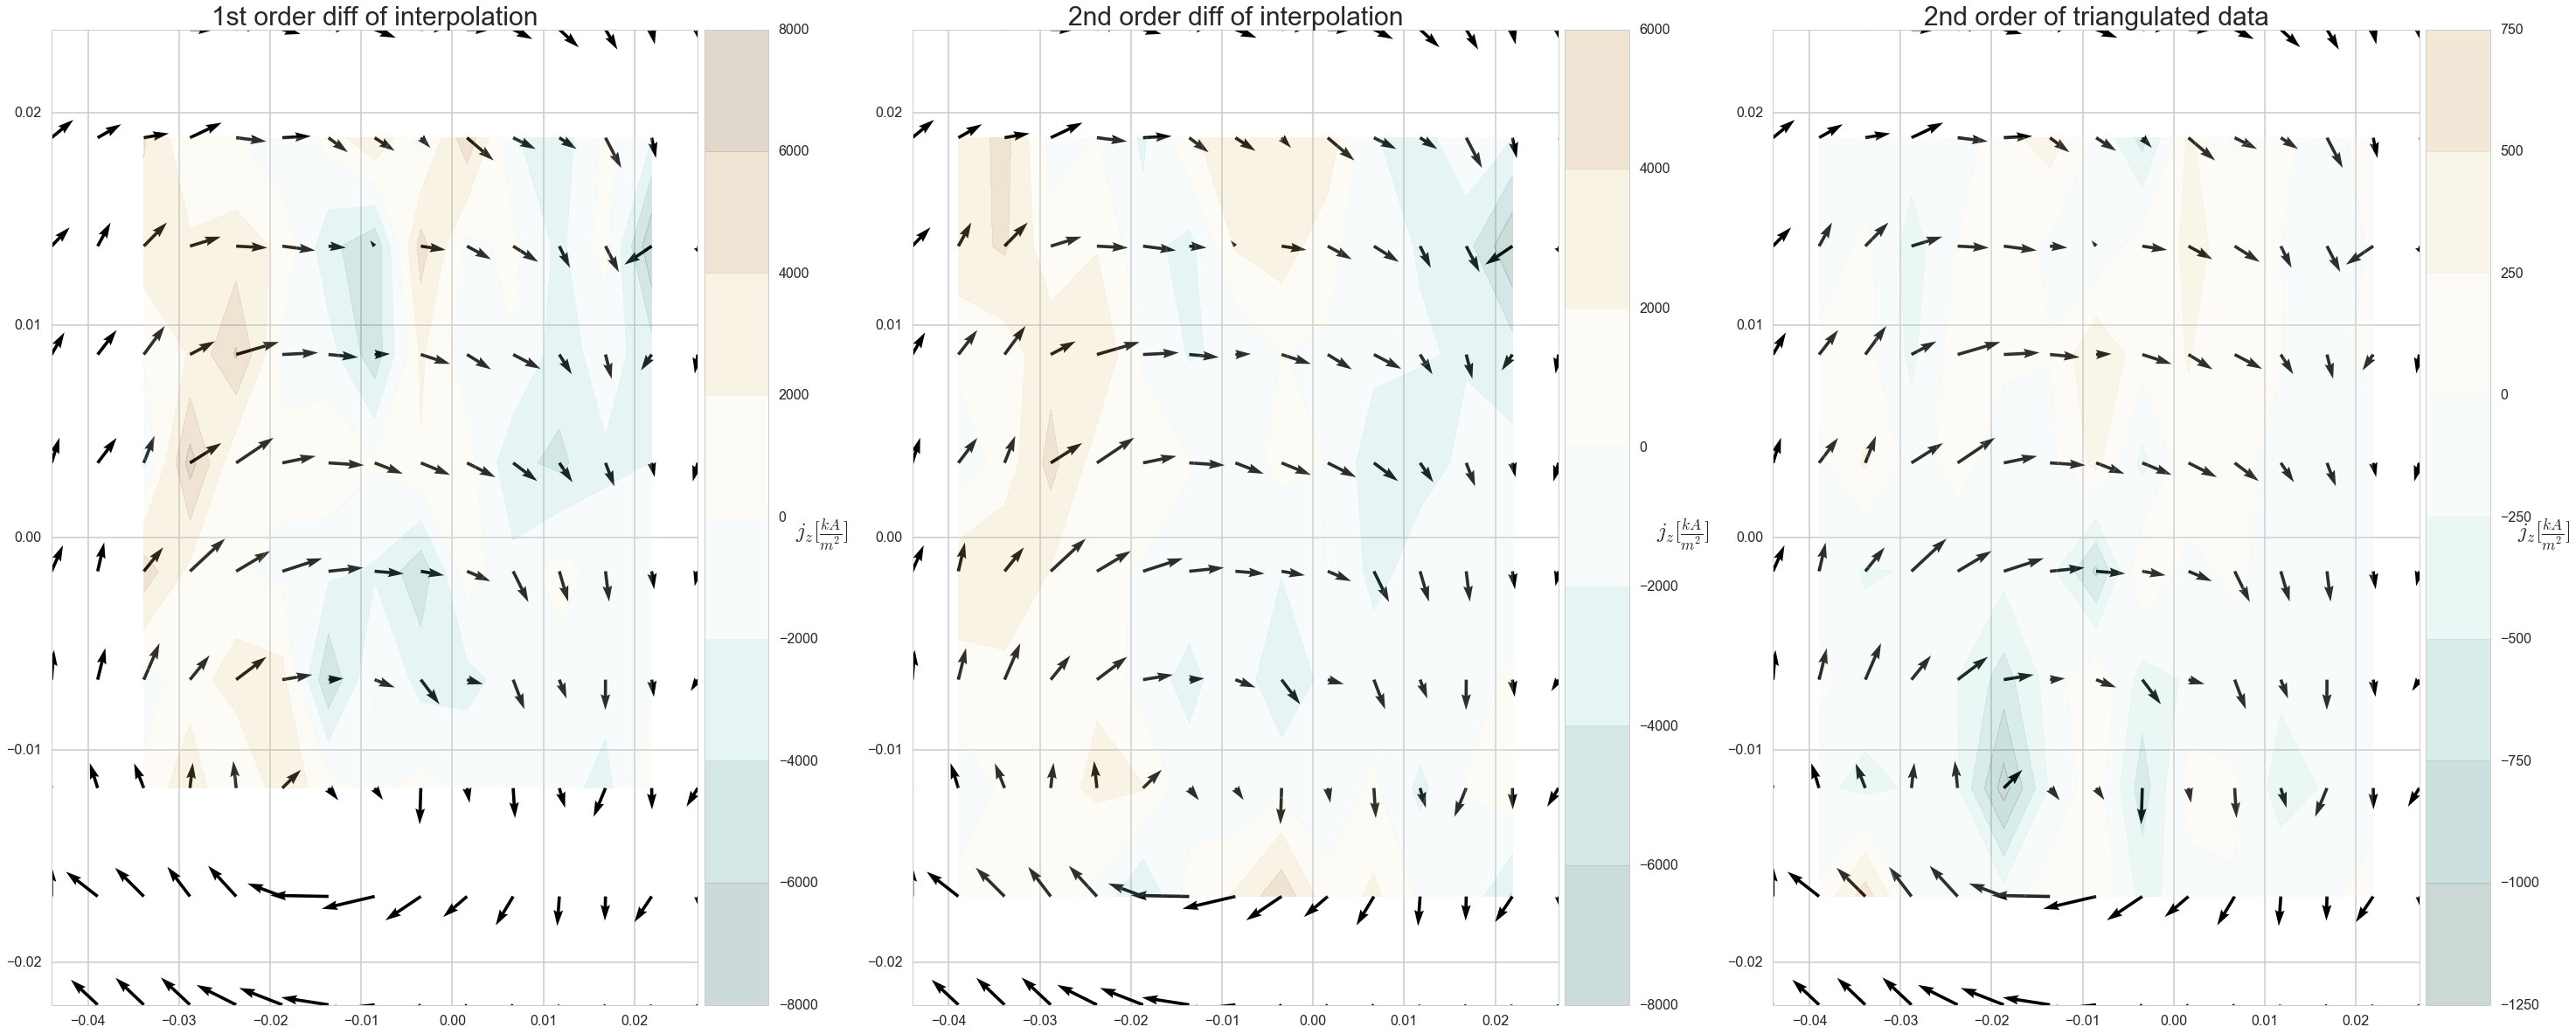

In [151]:
plot_three_current_methods(z0416_interpolated_vectors, 
                           z0416_tri_interpolators,
                           mesh, 0)

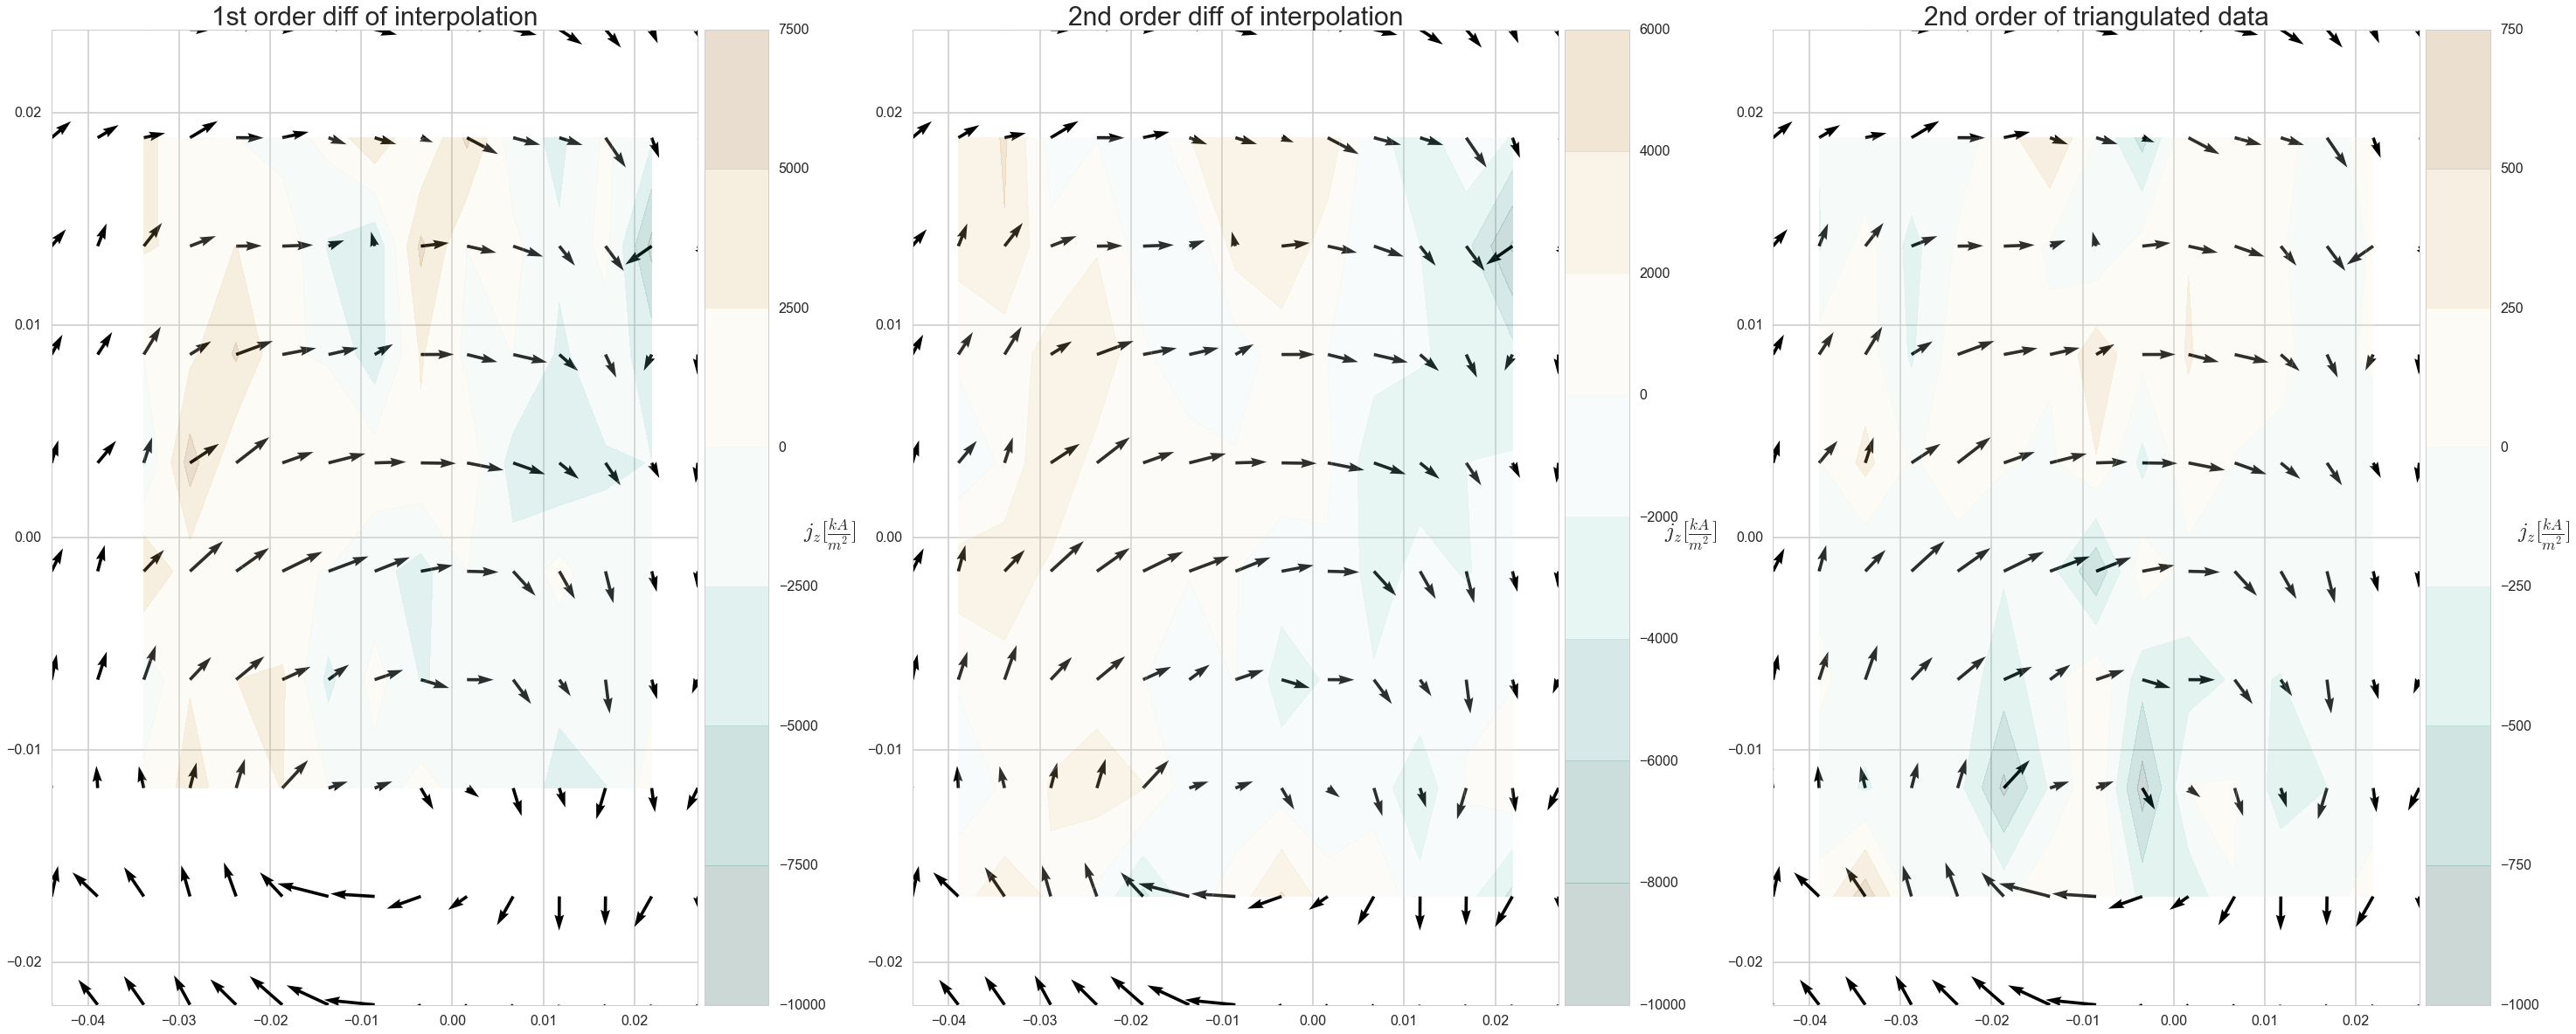

In [152]:
plot_three_current_methods(z0416_interpolated_vectors, 
                           z0416_tri_interpolators,
                           mesh, 1)

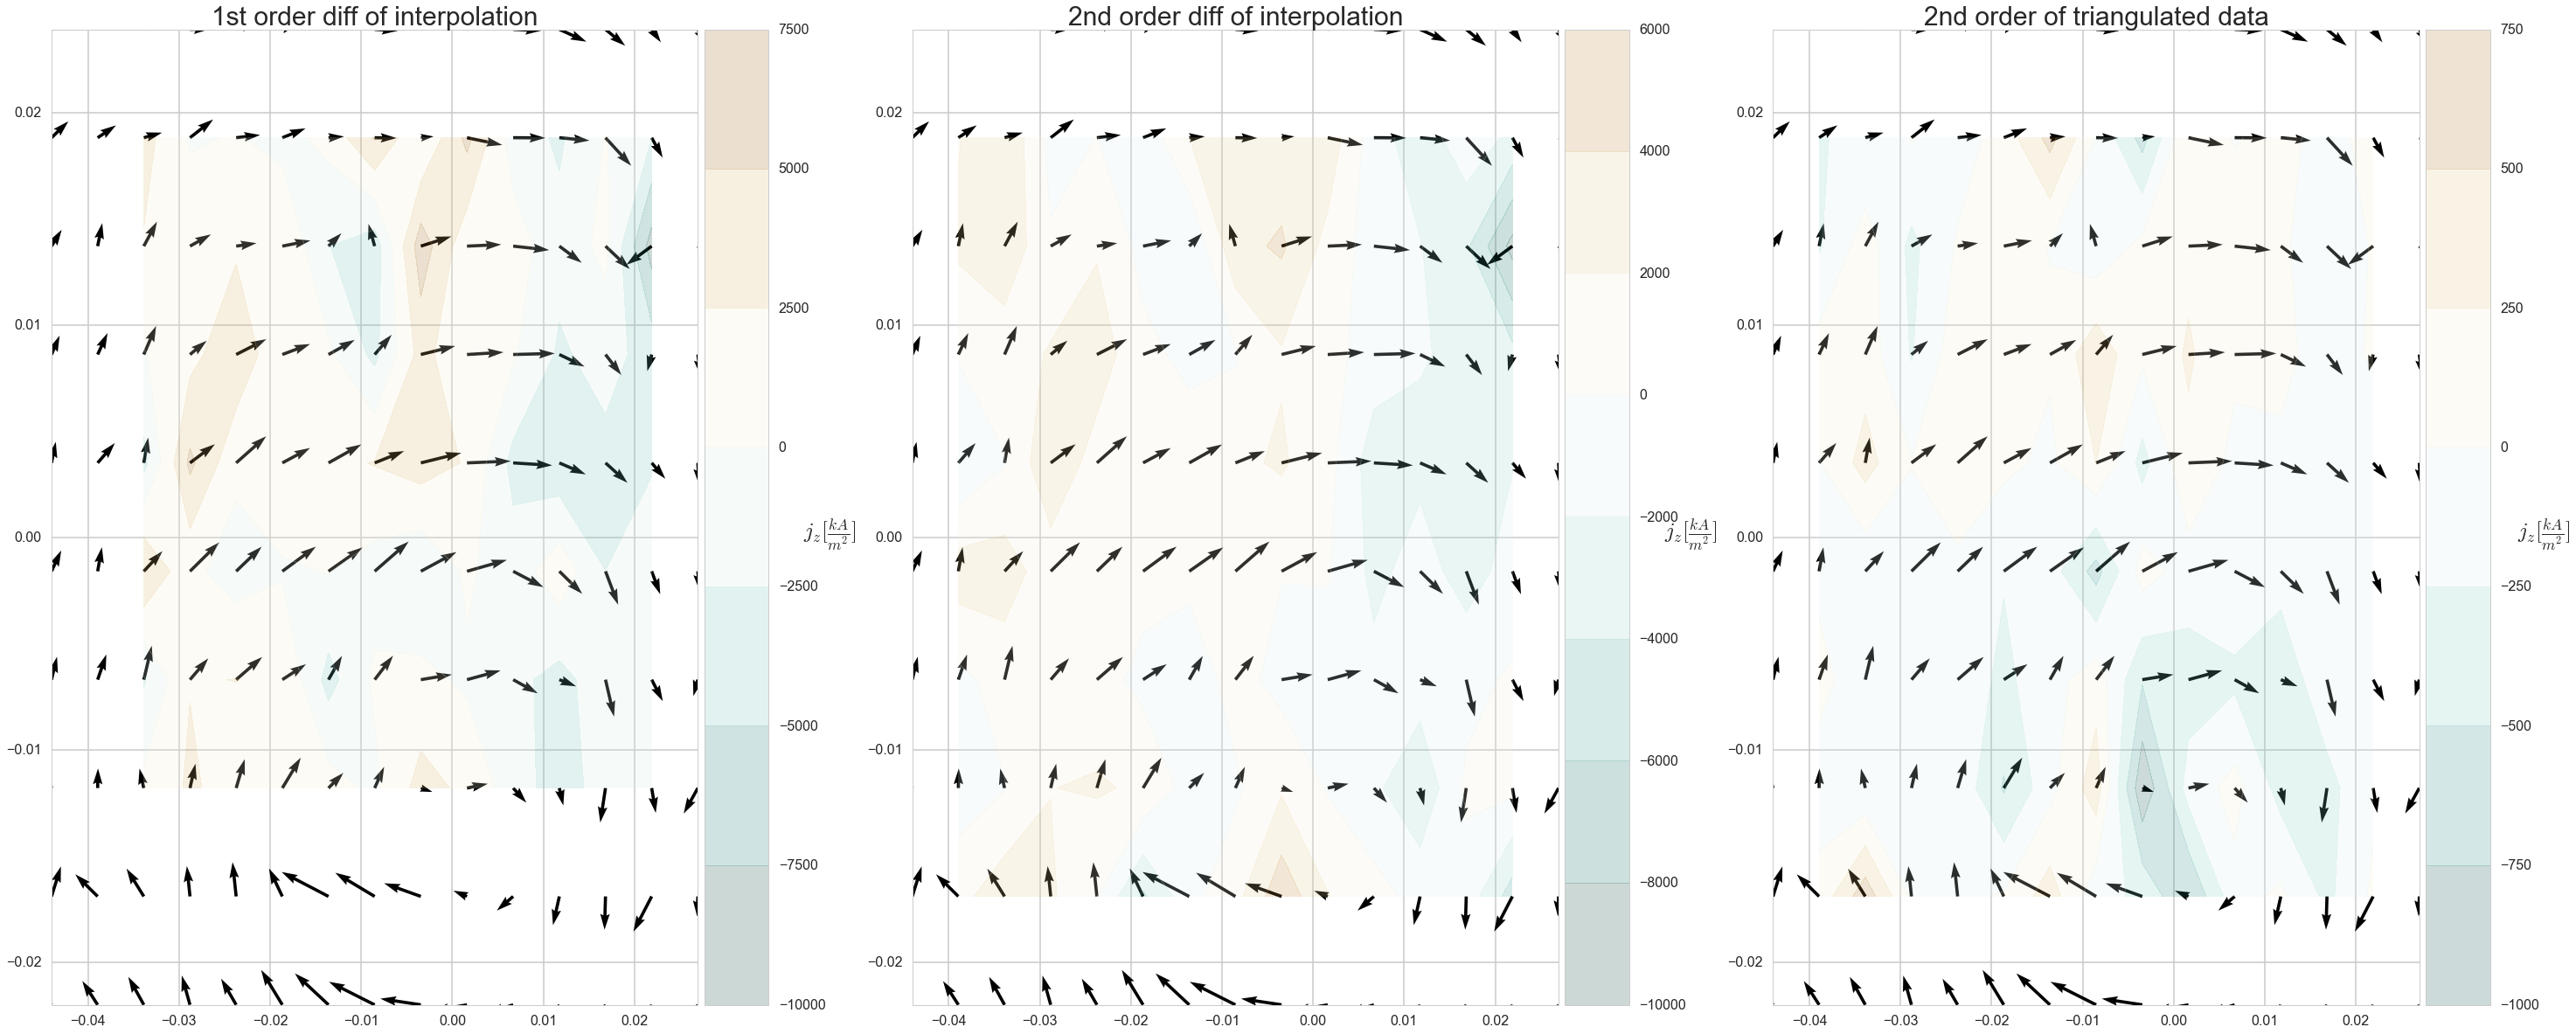

In [153]:
plot_three_current_methods(z0416_interpolated_vectors, 
                           z0416_tri_interpolators,
                           mesh, 2)

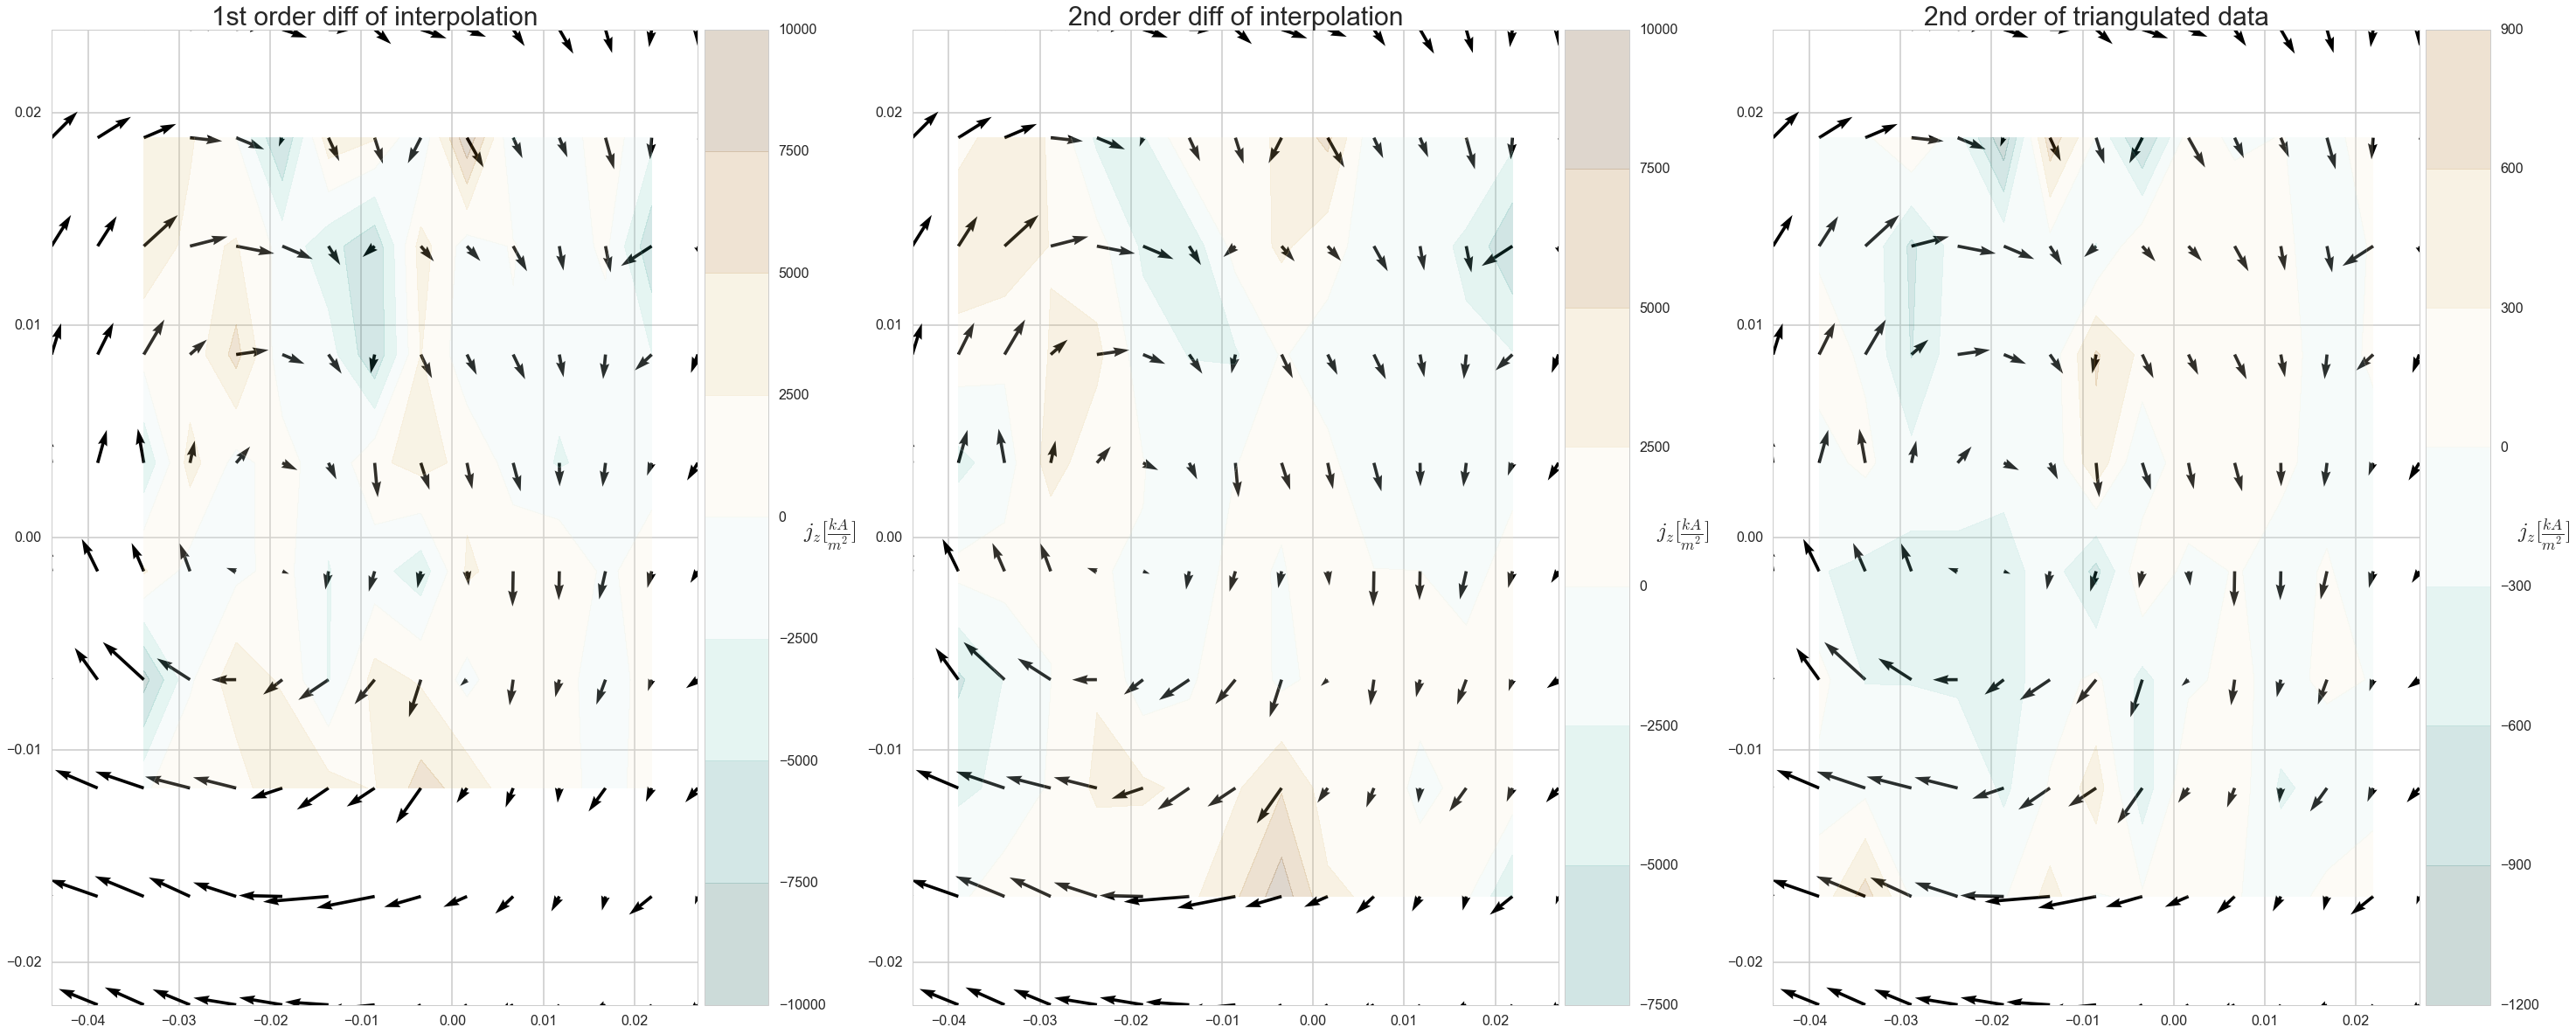

In [154]:
plot_three_current_methods(z0416_interpolated_vectors, 
                           z0416_tri_interpolators,
                           mesh, 18)

# Axial current z=0.357m plane

In [155]:
spatial_increment = 0.001
limits = extent.maximum_b_extent()[0.357]

mesh, grid_points = make_grid_points(spatial_increment=spatial_increment, **limits)

(z0357_interpolated_vectors,
 z0357_interpolators,
 z0357_tri_interpolators) = interpolate_plane(0.357, grid_points)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


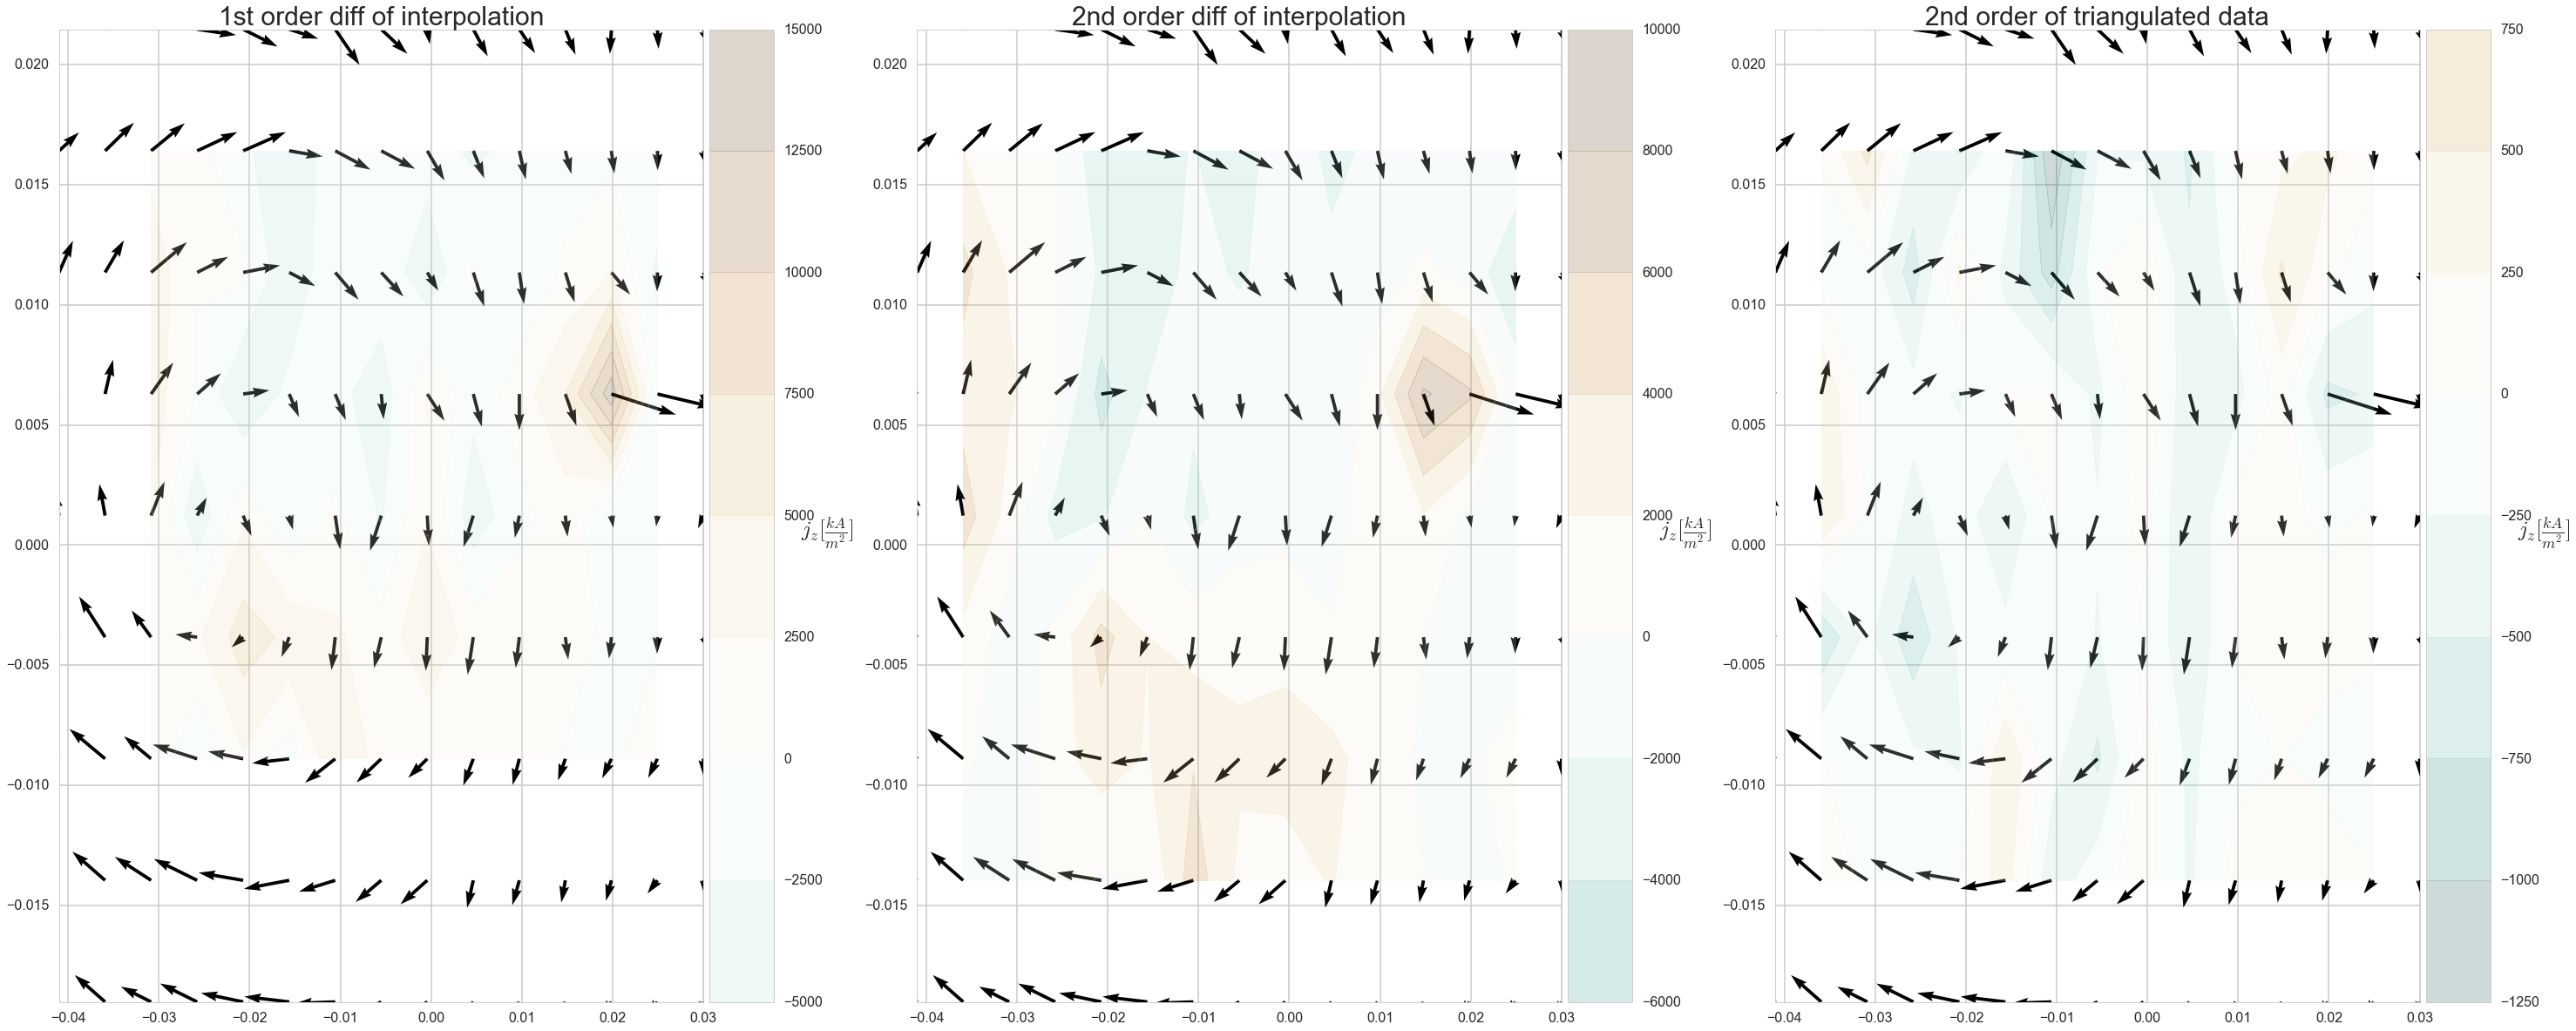

In [156]:
plot_three_current_methods(z0357_interpolated_vectors, 
                           z0357_tri_interpolators,
                           mesh, 18)

# Axial current z=0.302m plane

In [160]:
spatial_increment = 0.001
limits = extent.maximum_b_extent()[0.302]

mesh, grid_points = make_grid_points(spatial_increment=spatial_increment, **limits)

(z0302_interpolated_vectors,
 z0302_interpolators,
 z0302_tri_interpolators) = interpolate_plane(0.302, grid_points)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


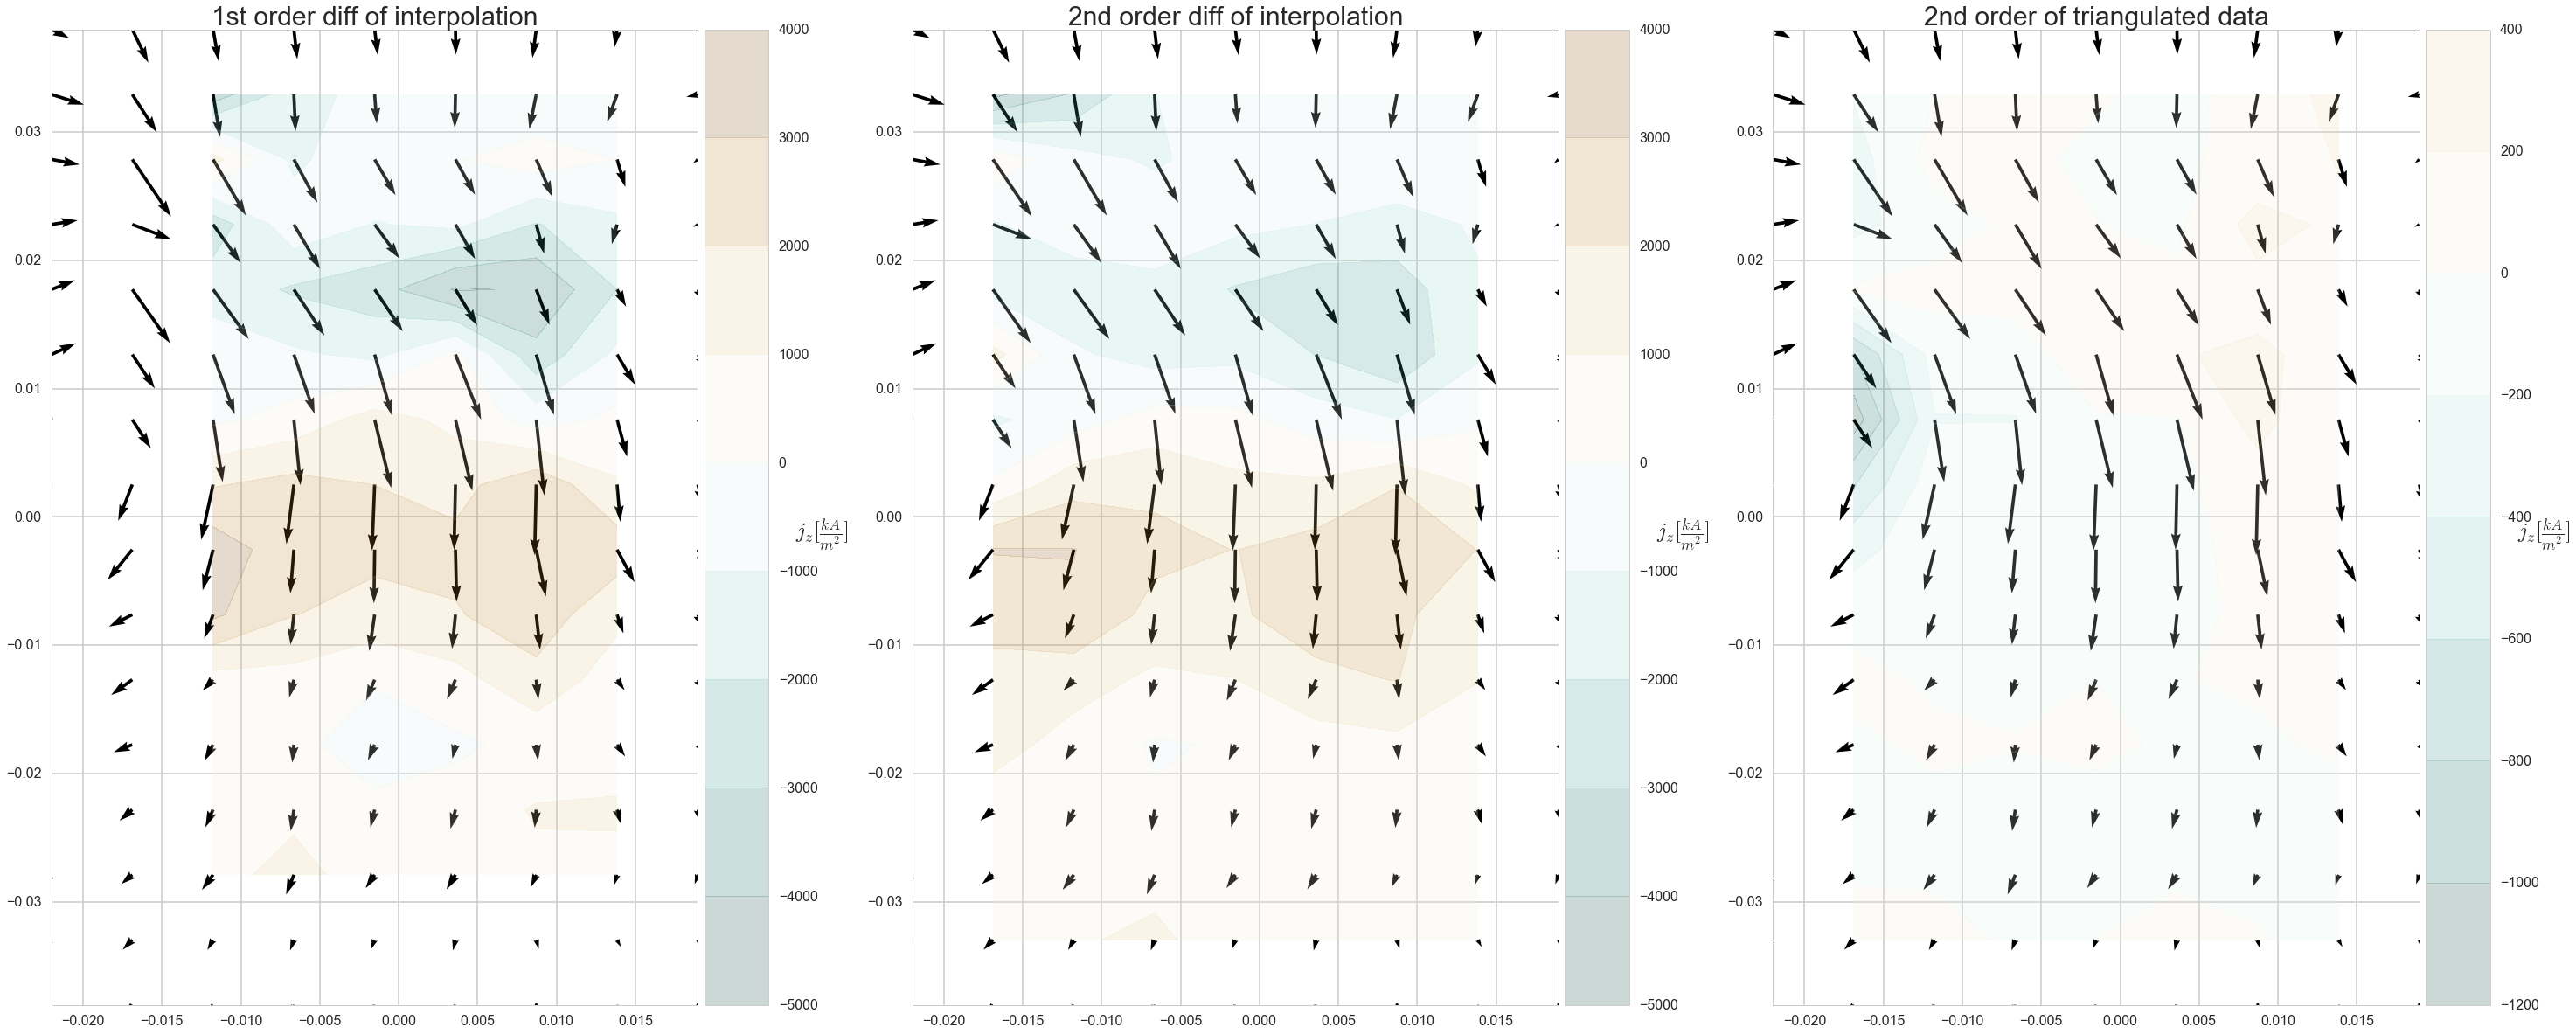

In [161]:
plot_three_current_methods(z0302_interpolated_vectors, 
                           z0302_tri_interpolators,
                           mesh, 18)

# Axial current z=0.249m plane

In [164]:
spatial_increment = 0.001
limits = extent.maximum_b_extent()[0.249]

mesh, grid_points = make_grid_points(spatial_increment=spatial_increment, **limits)

(z0249_interpolated_vectors,
 z0249_interpolators,
 z0249_tri_interpolators) = interpolate_plane(0.249, grid_points)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


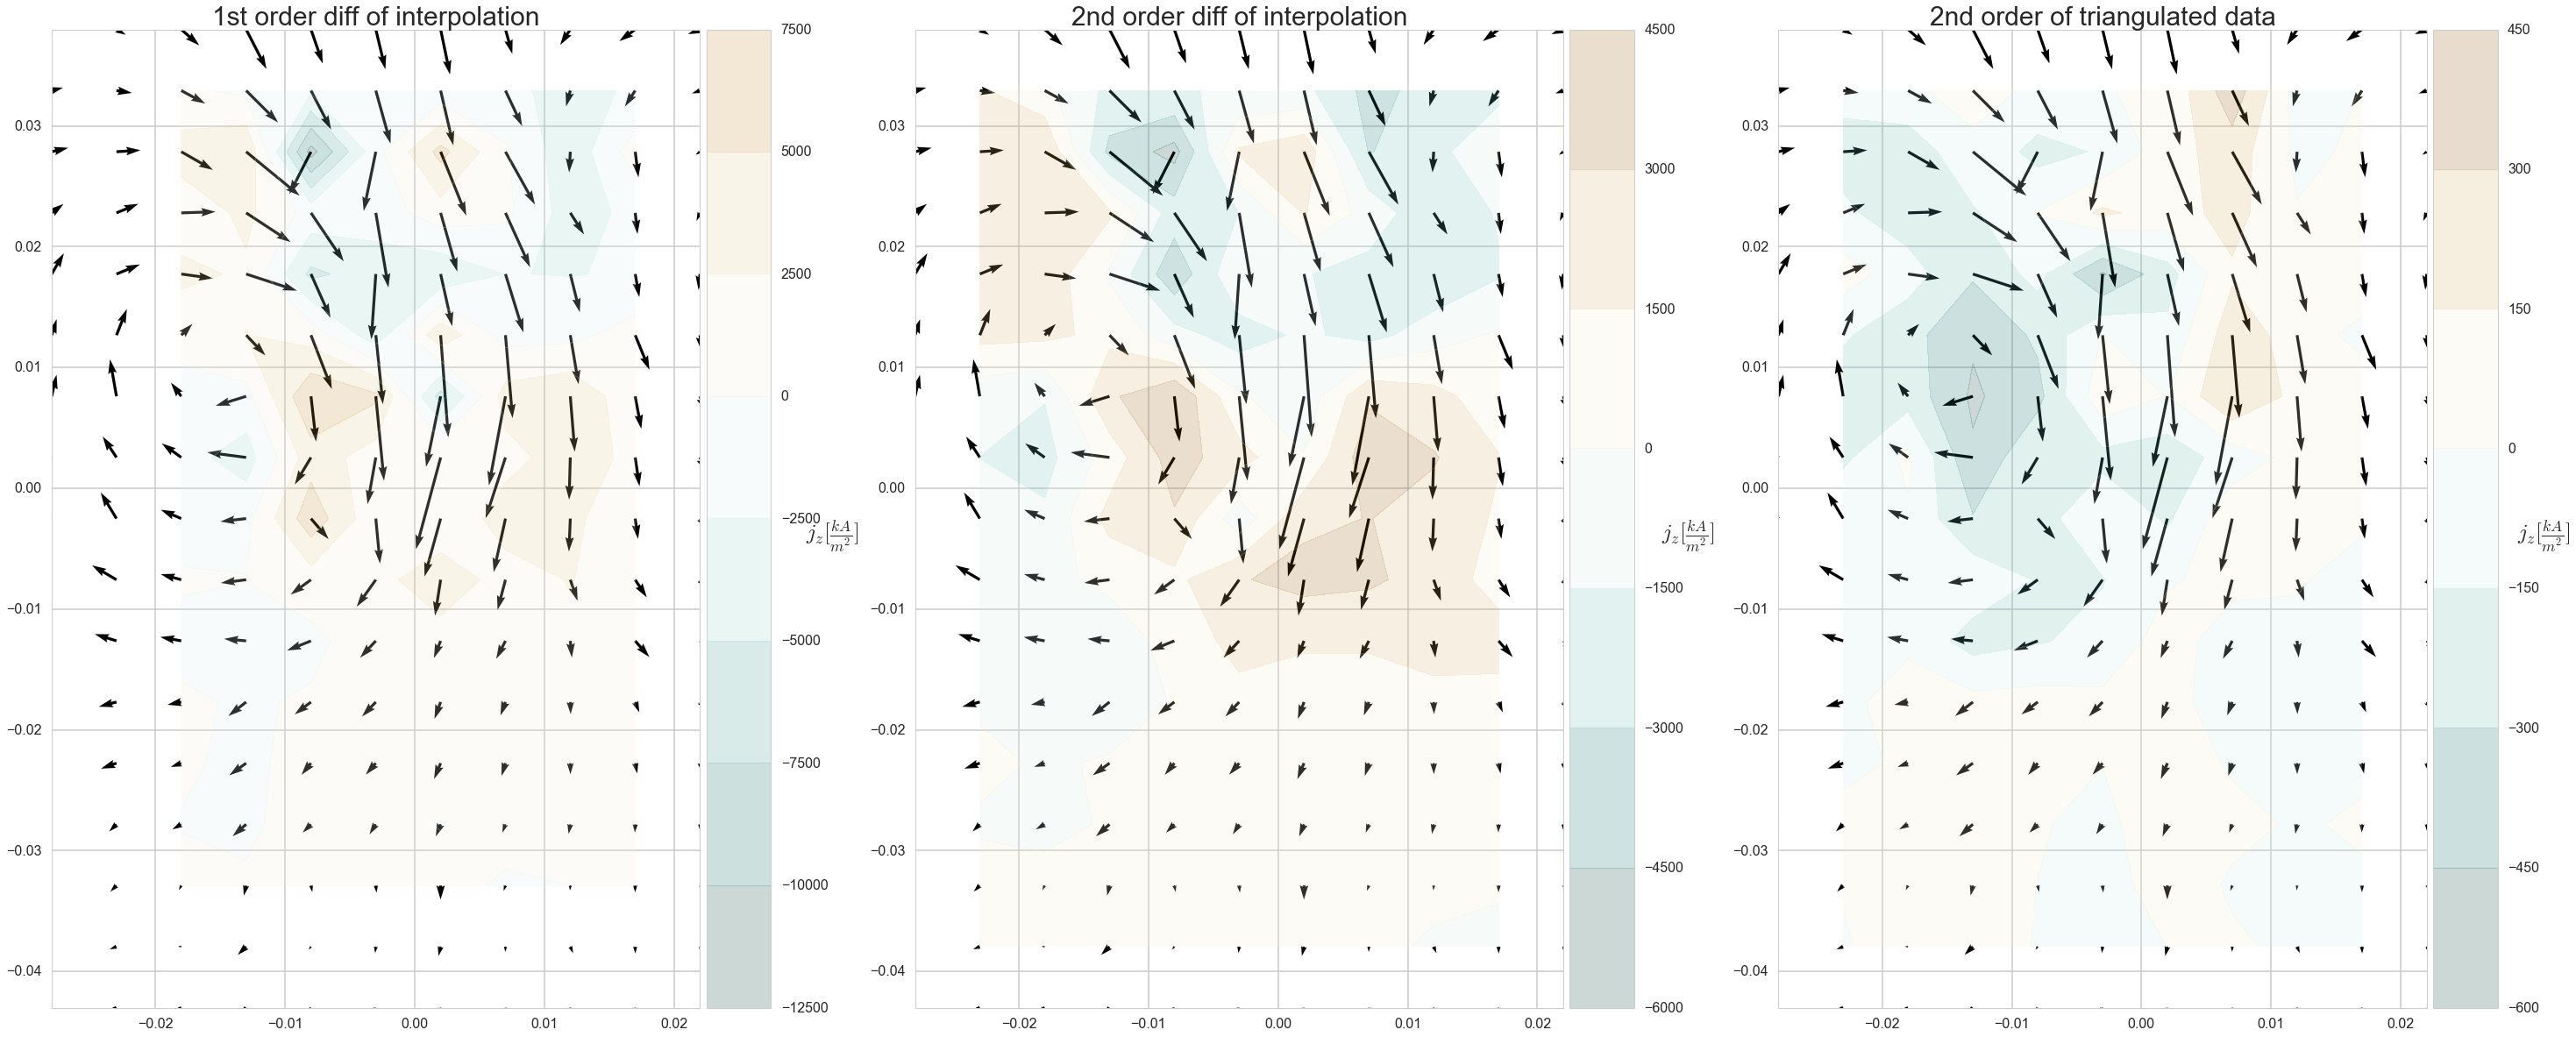

In [166]:
plot_three_current_methods(z0249_interpolated_vectors, 
                           z0249_tri_interpolators,
                           mesh, 18)

In [ ]:
|